<a href="https://colab.research.google.com/github/Okocha76/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



## Write function prob_drunk_given_positive

In [1]:
prob_drunk_prior = 1/1000
false_positive_rate = 8/100
true_positive_rate = 1

def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):
  return (true_positive_rate*prob_drunk_prior)/((true_positive_rate*prob_drunk_prior) + (false_positive_rate*(1-prob_drunk_prior)))

num_tests = 0
confidence = 0.95
output = []

while prob_drunk_prior < confidence:
  num_tests += 1
  prob_drunk_prior = prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate)
  output.append(prob_drunk_prior)

first = output[0]
print(f"Probability that a person is drunk after 1 positive breathalyzer test: {first}")

second = output[1]
print(f"\nProbability that a person is drunk after 2 positive breathalyzer tests: {second}")

print(f"\nProbability that a person is drunk after n positive breathalyzer tests:\n{output}")
print(f"\nConclusion: {num_tests} positive breathalyzer tests are needed in order to have a probability > 95% that a person is drunk.")

Probability that a person is drunk after 1 positive breathalyzer test: 0.012357884330202669

Probability that a person is drunk after 2 positive breathalyzer tests: 0.13525210993291495

Probability that a person is drunk after n positive breathalyzer tests:
[0.012357884330202669, 0.13525210993291495, 0.6615996951348605, 0.9606895076105054]

Conclusion: 4 positive breathalyzer tests are needed in order to have a probability > 95% that a person is drunk.


## Difference between Bayesian and Frequentist statistics

Bayesians allow for observed frequencies ("objective information") to be updated or modified with a priori ("subjective") information, making for stronger a posteriori information while Frequentists don't.

## Explore scipy.stats.bayes_mvs

In [0]:
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data", header=None, names=column_headers, na_values="?")
df = df.replace({'y': 1, 'n': 0})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
rep = df[df['party']=='republican']
dem = df[df['party']=='democrat']

In [5]:
def bayesian_dataframe(df):
  
  bayesian_output = []
  
  # Turn dataframe into a numpy array
  # List values by column and not by row
  df = df.values.T
  
  # Remove nan values from columns
  for col in df:
    cleaned_col = col[~np.isnan(col)]
    
    # Calculate Bayesian statistics for each issue
    mean_bayes_ci, _, _ = stats.bayes_mvs(cleaned_col, alpha=.95)
    bayesian_output.append(mean_bayes_ci)
    
  bayesian_output = pd.DataFrame(bayesian_output, columns=['mean', 'minmax'])
    
  return bayesian_output

# We only want the issue columns not the string "party" column
only_votes = dem.drop('party', axis='columns')

bayesian_output_df = bayesian_dataframe(only_votes)
bayesian_output_df.head()

,mean,minmax
0,0.604651,"(0.5445926997425515, 0.6647096258388437)"
1,0.502092,"(0.43824514095228484, 0.5659389594661252)"
2,0.888462,"(0.8499435153340716, 0.9269795615890052)"
3,0.054054,"(0.02633186149720885, 0.08177624661089927)"
4,0.215686,"(0.1648631139997972, 0.26650943501981067)"


In [6]:
bayesian_output_df[['lower', 'upper']] = bayesian_output_df['minmax'].apply(pd.Series)

bayesian_output_df = bayesian_output_df.drop('minmax', axis='columns')

bayesian_output_df

,mean,lower,upper
0,0.604651,0.544593,0.664710
1,0.502092,0.438245,0.565939
2,0.888462,0.849944,0.926980
3,0.054054,0.026332,0.081776
4,0.215686,0.164863,0.266509
5,0.476744,0.415392,0.538097
6,0.772201,0.720782,0.823620
7,0.828897,0.783085,0.874710
8,0.758065,0.704394,0.811735
9,0.471483,0.410757,0.532208


## Visualization Bayesian results

In [0]:
import matplotlib.pyplot as plt

Text(0, 0.5, "Percent of Democrats voting 'yes'")

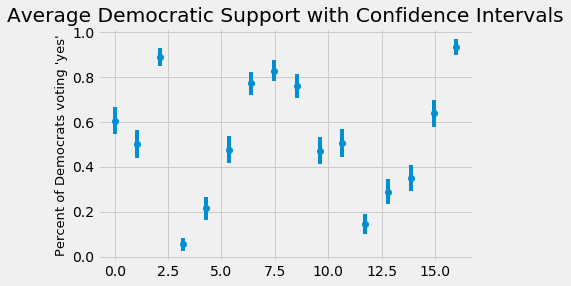

In [8]:
x = np.linspace(0, bayesian_output_df.shape[0], bayesian_output_df.shape[0])
y = bayesian_output_df['mean']
yerr = bayesian_output_df['upper'] - bayesian_output_df['mean']

plt.style.use('fivethirtyeight')
plt.errorbar(x, y, yerr, fmt='o');
plt.title('Average Democratic Support with Confidence Intervals')
plt.ylabel("Percent of Democrats voting 'yes'", fontsize=13)

## Visualization Frequentist results

In [0]:
def confidence_interval(data, confidence=0.95):
 
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

In [10]:
def confidence_interval_dataframe(df):
  
  confidence_intervals = []
  
  # Turn dataframe into a numpy array
  # List values by column and not by row
  df = df.values.T
  
  # Remove nan values from columns
  cleaned_df = []
  for col in df:
    cleaned_col = col[~np.isnan(col)]
    
    # Calculate Confidence interval for each issue
    confidence_intervals.append(confidence_interval(cleaned_col))
    
  confidence_intervals = pd.DataFrame(confidence_intervals, columns=['mean', 'lower', 'upper'])  
    
  return confidence_intervals

# We only want the issue columns not the string "party" column
only_votes = dem.drop('party', axis='columns')

confidence_interval_df = confidence_interval_dataframe(only_votes)
confidence_interval_df.head(20)

,mean,lower,upper
0,0.604651,0.544593,0.664710
1,0.502092,0.438245,0.565939
2,0.888462,0.849944,0.926980
3,0.054054,0.026332,0.081776
4,0.215686,0.164863,0.266509
5,0.476744,0.415392,0.538097
6,0.772201,0.720782,0.823620
7,0.828897,0.783085,0.874710
8,0.758065,0.704394,0.811735
9,0.471483,0.410757,0.532208


In [11]:
confidence_interval_df['margin_of_error'] = confidence_interval_df['upper'] - confidence_interval_df['mean']

print(confidence_interval_df.shape)
confidence_interval_df.head()

(16, 4)


,mean,lower,upper,margin_of_error
0,0.604651,0.544593,0.664710,0.060058
1,0.502092,0.438245,0.565939,0.063847
2,0.888462,0.849944,0.926980,0.038518
3,0.054054,0.026332,0.081776,0.027722
4,0.215686,0.164863,0.266509,0.050823


Text(0, 0.5, "Percent of Democrats voting 'yes'")

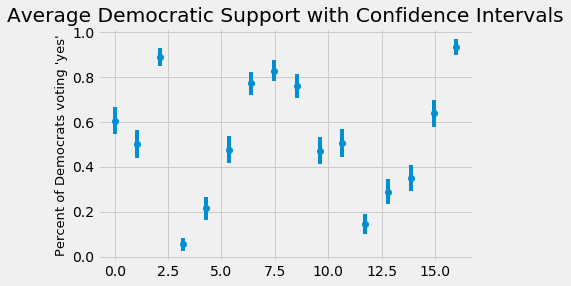

In [12]:
x = np.linspace(0, confidence_interval_df.shape[0], confidence_interval_df.shape[0])
y = confidence_interval_df['mean']
yerr = confidence_interval_df['margin_of_error']


plt.style.use('fivethirtyeight')
plt.errorbar(x, y, yerr, fmt='o');
plt.title('Average Democratic Support with Confidence Intervals')
plt.ylabel("Percent of Democrats voting 'yes'", fontsize=13)

## Compare Bayesian and Frequentist results

In [13]:
bayes_frequentist = bayesian_output_df - confidence_interval_df.drop('margin_of_error', axis='columns')
bayes_frequentist

,mean,lower,upper
0,0.0,0.000000e+00,0.0
1,0.0,0.000000e+00,0.0
2,0.0,0.000000e+00,0.0
3,0.0,0.000000e+00,0.0
4,0.0,0.000000e+00,0.0
5,0.0,0.000000e+00,0.0
6,0.0,0.000000e+00,0.0
7,0.0,0.000000e+00,0.0
8,0.0,0.000000e+00,0.0
9,0.0,-5.551115e-17,0.0


Conclusion: Bayesian & Frequentist approach give pretty much the same results.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!